# 1. 전처리 단계 개요
- 이상값 및 결측값 확인 -> 대체하거나 삭제 (의학적 지식 활용)
- outcome 값은 더미변수로 설정
- outcome 값의 불균형여부확인
- 테스트데이터/학습데이터 구분
- 각변수들의 상관행렬 ( 다중공선성 극복방법: 변수버리기, 인덱싱)
- 정규화 (선택)


# 2. 랜덤포레스트
- 정의: 여러개의 의사결정나무를 만들어서 결과를 투표하거나 평균 내서 예측하는 앙상블 모델
- 부트스트랩(Bootstrap): 무작위 샘플링하여 여러개의 데이터셋 만듬 (중복허용)
- 배깅: 데이터 샘플링 기법으로, 부트스트랩으로 여러 개의 훈련 데이터셋을 생성후, 독립적인 모델 학습시키는 방법
- 노드: 질문을 던지는 지점으로 루트노드(첫 노드), 내부노드(이후 노드), 리프노드(마지막 노드)
- 정보이득: 질병있는 그룹 vs 있는 그룹을 얼마나 깨끗이 분리하는지? -> 정량적공식 존재 (엔트로피, 정보이득, 지니지수등 공식)


# 3. 일반적(통계적) 상관성
- pregnancies , Age (중간)
- Clucose , insulin
- bmi , skinthickness
- bmi, insulin (중간)

# 3. 전처리 과정

In [13]:
# csv 파일불러오고 데이터 확인
import pandas as pd

df=pd.read_csv("C:\MyPython\diabetes.csv")
print(df.head(10))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   2

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\qkrrl\AppData\Local\Temp\ipykernel_13960\3026802215.py:4: SyntaxWarning: invalid escape sequence '\M'
  df=pd.read_csv("C:\MyPython\diabetes.csv")


# 결측치,이상치 탐지 및 대체
- 결측치가 있는 변수의 분포확인
- insulin의 경우 0은 불가능한 값임 -> 많이 편향되지 않았다면 중앙값 또는 회귀 기반 대체 활용
- 플롯그리고 IQR로 이상치 판단



In [22]:
## 결측치 확인
import numpy as np
print(df.isna().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [23]:
## 결측치 중앙값으로 대체
miss_c = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [24]:
## 0을 NaN으로 변환
df[miss_c] = df[miss_c].replace(0, np.nan)

In [25]:
## 중앙값으로 결측치 대체
for col in miss_c:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)


In [ ]:
## 남은 결측치 여부 확인
print(df.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [26]:
# 이상치 확인 -> 의학적으로 이상치 아닐 가능성
## 분석할 수치형 변수 (종속변수 제외)
numeric_cols = df.drop(columns='Outcome').columns

In [27]:
## 이상치 개수 IQR
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outlier_counts[col] = outlier_count

Pregnancies: 4개
Glucose: 0개
BloodPressure: 14개
SkinThickness: 87개
Insulin: 346개
BMI: 8개
DiabetesPedigreeFunction: 29개
Age: 9개


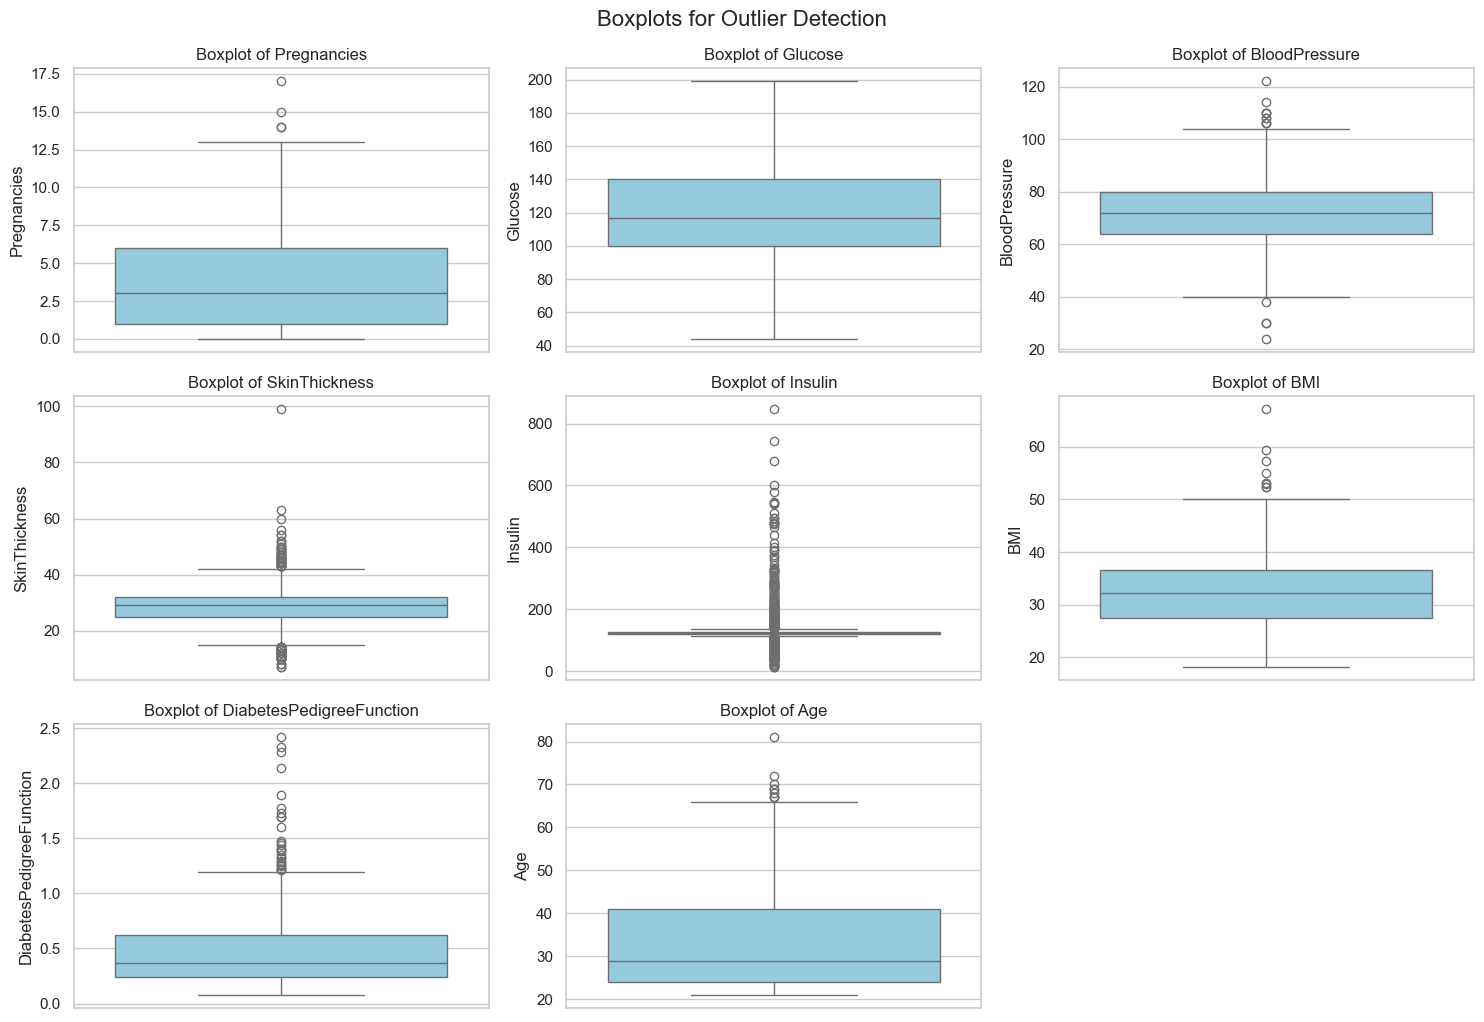

In [ ]:
## 결과 출력(이상치 개수)
for col, count in outlier_counts.items():
    print(f"{col}: {count}개")

## 시각화
# import matplotlib.pyplot as plt
# import seaborn as sns
sns.set(style="whitegrid")
numeric_cols = df.drop(columns='Outcome').columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

plt.suptitle("Boxplots for Outlier Detection", fontsize=16, y=1.02)
plt.show()

# 이상치 판단
- pregnancies: 10회가 넘는 임신횟수는 이상치로 판단
- BloodPressure: 분포를 보면 이완기 혈압으로 추정, 정확한 판단은 불가
- SkinThickness: 정확한 판단 불가
- Insulin: 단위 등 정확한 정보가 없어서 판단불가
- BMI: 이상치로 판단되는 수치를 가진 표본의 다른 열의 데이터값으로 보아 이상치는 아닌 것으로 판단
- DiabetesePedigreeFuntion: 판단불가
- Age: 나이가 80이 넘는 경우는 충분히 있을 수 있다고 판단

# 4. 변수간 상관성 분석
- 주어진 데이터에서 상관행렬 작성 
- 다중공선성 발생가능성 인지



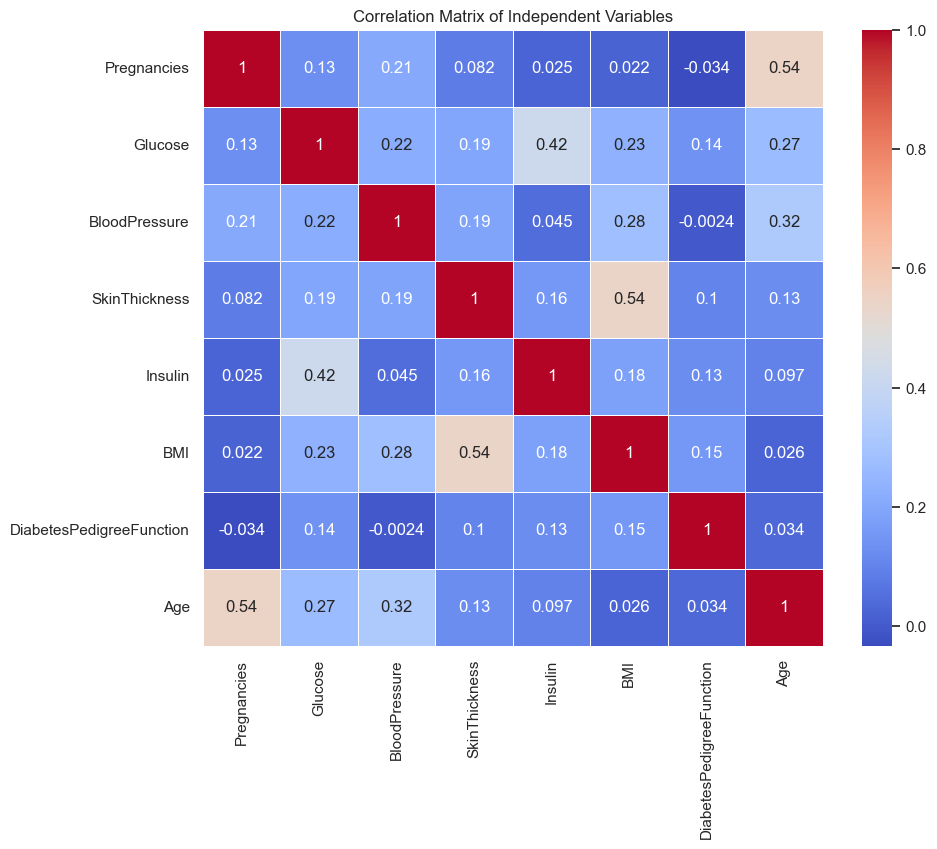

In [ ]:
# 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 계산 (독립변수만)
corr_matrix = df.drop(columns='Outcome').corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Independent Variables")
plt.show()


#5 모든 변수의 치우침 정도 그래프로 확인




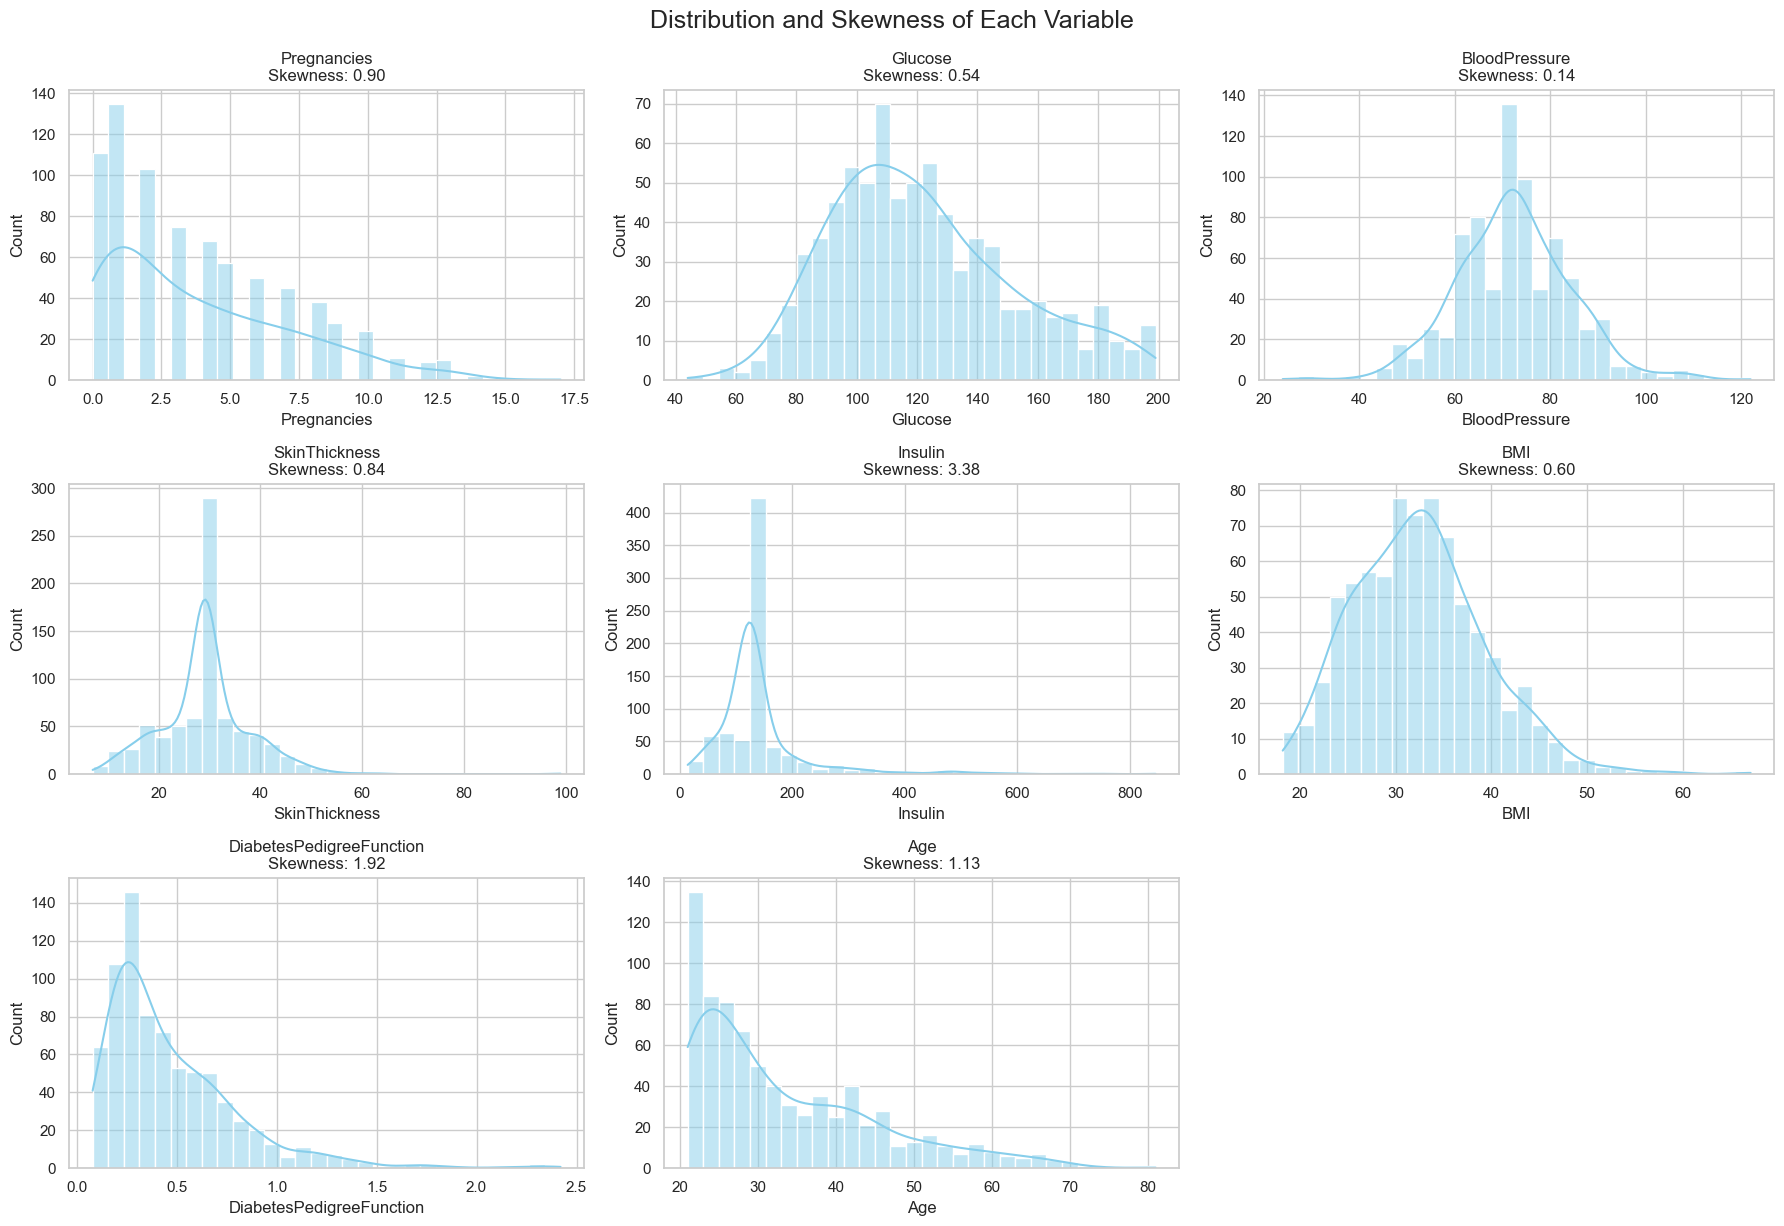

In [ ]:
##라이브ㄹㅓ리
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 대상 변수 (종속변수 제외)
numeric_cols = df.drop(columns='Outcome').columns

# 플롯
plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    skew_val = df[col].skew()
    plt.title(f"{col}\nSkewness: {skew_val:.2f}")
    plt.tight_layout()

plt.suptitle("Distribution and Skewness of Each Variable", fontsize=18, y=1.02)
plt.show()

#6 데이터셋 분리
## train, valid, test 셋으로 분리



In [33]:
from sklearn.model_selection import train_test_split

# 독립변수와 종속변수 분리
X = df.drop(columns='Outcome')
y = df['Outcome']

# Train(60%) vs Temp(40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42)

# Validation(20%) vs Test(20%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 확인
print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_valid.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 460
Validation size: 154
Test size: 154
